
IBM Data Science Capstone Project

This notebook will guide you through a theoretical business problem. The question that we are trying to answer is the following: 

A family planning to move to Singapore with school aged children. For the first year, mother wanted to stay at a place near to many schools. 
Reasons:

1) They have 5 children that are still in school.
2) Father/husband works as teacher, plan to tutor after-class school students as a hobby.
3) Mother works from home, the company she is working requires her to come once a month only, located near the Changi airport.

Here in our project we will check all the Schools that are present in different region of Singapore. We will analyse the data Singpore's region and see where the schools are in highest number. We will check the proximity of each school according to Folium maps.We hope to answer :

"I have kids and plan to relocate to Singapore, which part of Singapore should I choose?"

To do this, we will need the following data:

List of the districts of Singapore and its coordinates -> this comes :https://simplemaps.com/data/sg-cities
Schools in Singapore -> Foursquare API is used to collect the venue data
Methodology: After tidying up the data, we will apply K-means machine learning technique for creating clusters of districts. We will use silhouette score for choosing the optimal number of clusters.

In [2]:
#1 Importing libraries

import numpy as np # library to handle data in a vectorized manner

import pandas as pd # library for data analsysis

import json # library to handle JSON files

#!conda install -c conda-forge geopy --yes 
#from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans

!conda install -c conda-forge folium=0.5.0 --yes
import folium # map rendering library


print('Libraries imported.')



EnvironmentNotWritableError: The current user does not have write permissions to the target environment.
  environment location: C:\ProgramData\Anaconda3




Solving environment: ...working... failed with initial frozen solve. Retrying with flexible solve.
Solving environment: ...working... done

## Package Plan ##

  environment location: C:\ProgramData\Anaconda3

  added / updated specs:
    - folium=0.5.0


The following NEW packages will be INSTALLED:

  altair             conda-forge/noarch::altair-4.1.0-py_1
  branca             conda-forge/noarch::branca-0.4.2-pyhd8ed1ab_0
  folium             conda-forge/noarch::folium-0.5.0-py_0
  vincent            conda-forge/noarch::vincent-0.4.4-py_1

The following packages will be SUPERSEDED by a higher-priority channel:

  openssl                                         pkgs/main --> conda-forge


Preparing transaction: ...working... done
Verifying transaction: ...working... failed
Libraries imported.


In [4]:
df_data_1 = pd.read_csv(r"C:\Users\Lenovo X1 Carbon\Desktop\ilmi\singapore_csv.csv")
df_data_1.head()

,country,Districts,city,lat,lng,Unnamed: 5
0,Singapore,South West,Keat Hong Village,1.3778,103.7442,NaN
1,Singapore,South West,Choa Chu Kang New Town,1.3833,103.7500,NaN
2,Singapore,South West,Bukit Panjang Estate,1.3817,103.7525,NaN
3,Singapore,Central Singapore,Jalan Kayu,1.3972,103.8719,NaN
4,Singapore,Central Singapore,Bukit Sembawang Estate,1.3956,103.8692,NaN


In [8]:
df_data_1.shape

(74, 6)

In [6]:
!conda install -c conda-forge geopy --yes 
from geopy.geocoders import Nominatim

Solving environment: ...working... done

# All requested packages already installed.



In [ ]:
#H3 Mapping Singapore with the 74 cities

First, let's find the geodata for Singapore

In [9]:
address = 'Central Singapore, Singapore'

geolocator = Nominatim(user_agent="sg_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Central Singapore, Singapore are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Central Singapore, Singapore are 1.3156186, 103.8536256.


In [ ]:
#H3 Create a map of New York with neighborhoods superimposed on top

In [10]:
# create map of New York using latitude and longitude values
map_sg = folium.Map(location=[latitude, longitude], zoom_start=10)

# add markers to map
for lat, lng, districts, city in zip(df_data_1['lat'], df_data_1['lng'], df_data_1['Districts'], df_data_1['city']):
    label = '{}, {}'.format(districts, city)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_sg)  
    
map_sg

#H3 Exploring the Districts

#Exploring Schools with Foursquare
Foursquare credentials


In [14]:
CLIENT_ID = 'ZVYUAIUMPN1PO2Y4INBDNCM2BIX5MHNO5OT2YCNCUFDQOKIQ' # your Foursquare ID
CLIENT_SECRET = 'SVFDWK2BFQFMUXQNV3ZTPK2A20RP435SW0XZ13HI2ZPZJD44' # your Foursquare Secret
ACCESS_TOKEN = 'MF3CFNBPEGWJG5TMRJA5TXHVFTLSEWEKX4EEPI1CM1AEECWF' # your FourSquare Access Token
VERSION = '20180604'
LIMIT = 30
print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: ZVYUAIUMPN1PO2Y4INBDNCM2BIX5MHNO5OT2YCNCUFDQOKIQ
CLIENT_SECRET:SVFDWK2BFQFMUXQNV3ZTPK2A20RP435SW0XZ13HI2ZPZJD44


In [16]:
df_data_1.loc[0, 'Districts']

'South West'

In [17]:
neighborhood_latitude = df_data_1.loc[0, 'lat'] # neighborhood latitude value
neighborhood_longitude = df_data_1.loc[0, 'lng'] # neighborhood longitude value

neighborhood_name = df_data_1.loc[0, 'Districts'] # neighborhood name

print('Latitude and longitude values of {} are {}, {}.'.format(neighborhood_name, 
                                                               neighborhood_latitude, 
                                                               neighborhood_longitude))

Latitude and longitude values of South West are 1.3778, 103.7442.


In [18]:

LIMIT = 100 # limit of number of venues returned by Foursquare API
radius = 500 # define radius

# create URL
url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
    CLIENT_ID, 
    CLIENT_SECRET, 
    VERSION, 
    neighborhood_latitude, 
    neighborhood_longitude, 
    radius, 
    LIMIT)
url # display URL


'https://api.foursquare.com/v2/venues/explore?&client_id=ZVYUAIUMPN1PO2Y4INBDNCM2BIX5MHNO5OT2YCNCUFDQOKIQ&client_secret=SVFDWK2BFQFMUXQNV3ZTPK2A20RP435SW0XZ13HI2ZPZJD44&v=20180604&ll=1.3778,103.7442&radius=500&limit=100'

In [19]:
results = requests.get(url).json()
results

{'meta': {'code': 200, 'requestId': '601fcced2fb7cf11ea6d4680'},
 'response': {'suggestedFilters': {'header': 'Tap to show:',
   'filters': [{'name': 'Open now', 'key': 'openNow'}]},
  'headerLocation': 'Choa Chu Kang',
  'headerFullLocation': 'Choa Chu Kang, Singapore',
  'headerLocationGranularity': 'neighborhood',
  'totalResults': 6,
  'suggestedBounds': {'ne': {'lat': 1.3823000045000045,
    'lng': 103.74869290145848},
   'sw': {'lat': 1.3732999954999954, 'lng': 103.73970709854153}},
  'groups': [{'type': 'Recommended Places',
    'name': 'recommended',
    'items': [{'reasons': {'count': 0,
       'items': [{'summary': 'This spot is popular',
         'type': 'general',
         'reasonName': 'globalInteractionReason'}]},
      'venue': {'id': '4c9b2dc278ffa0939e7e7275',
       'name': 'KFC',
       'location': {'address': '#01-02, Keat Hong Shopping Centre',
        'crossStreet': '253 Choa Chu Kang Ave 1',
        'lat': 1.3772273644479736,
        'lng': 103.744419101957,
    

In [20]:
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

In [21]:
venues = results['response']['groups'][0]['items']
    
nearby_venues = json_normalize(venues) # flatten JSON

# filter columns
filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
nearby_venues =nearby_venues.loc[:, filtered_columns]

# filter the category for each row
nearby_venues['venue.categories'] = nearby_venues.apply(get_category_type, axis=1)

# clean columns
nearby_venues.columns = [col.split(".")[-1] for col in nearby_venues.columns]

nearby_venues.head()

<ipython-input-21-561c05f0fdd1>:3: FutureWarning: pandas.io.json.json_normalize is deprecated, use pandas.json_normalize instead
  nearby_venues = json_normalize(venues) # flatten JSON


,name,categories,lat,lng
0,KFC,Fast Food Restaurant,1.377227,103.744419
1,Keat Hong Shopping Centre,Miscellaneous Shop,1.377293,103.744429
2,85 Cafe,Food Court,1.377323,103.744407
3,Hong Kiat Seafood Restaurant,Coffee Shop,1.376468,103.743865
4,Bus Stop 44441 (Blk 239),Bus Station,1.379146,103.747471


In [22]:
print('{} venues were returned by Foursquare.'.format(nearby_venues.shape[0]))

6 venues were returned by Foursquare.


In [23]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [24]:
sg_venues = getNearbyVenues(names=df_data_1['Districts'],
                                   latitudes=df_data_1['lat'],
                                   longitudes=df_data_1['lng']
                                  )

South West
South West
South West
Central Singapore
Central Singapore
North East
South West
North West
North West
Central Singapore
Central Singapore
Central Singapore
Central Singapore
North East
North East
South West
South West
Central Singapore
North West
Central Singapore
South West
North East
North West
Central Singapore
Central Singapore
South West
South West
South East
South East
South East
South East
Central Singapore
South East
South West
Central Singapore
North West
North West
North West
North West
Central Singapore
Central Singapore
Central Singapore
South East
Central Singapore
Central Singapore
South West
Central Singapore
North West
South West
South West
South West
North West
North West
North West
Central Singapore
North West
South East
North East
North West
North West
South West
Central Singapore
North East
North West
North West
North West
North West
South West
North East
South West
South West
South West
South West
South West


In [25]:
print(sg_venues.shape)
sg_venues.head()

(1079, 7)


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,South West,1.3778,103.7442,KFC,1.377227,103.744419,Fast Food Restaurant
1,South West,1.3778,103.7442,Keat Hong Shopping Centre,1.377293,103.744429,Miscellaneous Shop
2,South West,1.3778,103.7442,85 Cafe,1.377323,103.744407,Food Court
3,South West,1.3778,103.7442,Hong Kiat Seafood Restaurant,1.376468,103.743865,Coffee Shop
4,South West,1.3778,103.7442,Bus Stop 44441 (Blk 239),1.379146,103.747471,Bus Station


In [27]:
sg_venues.groupby('Neighborhood').count()

,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighborhood,,,,,,
Central Singapore,255,255,255,255,255,255
North East,39,39,39,39,39,39
North West,264,264,264,264,264,264
South East,174,174,174,174,174,174
South West,347,347,347,347,347,347


In [28]:
print('There are {} uniques categories.'.format(len(sg_venues['Venue Category'].unique())))

There are 179 uniques categories.


In [29]:
# one hot encoding
sg_onehot = pd.get_dummies(sg_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
sg_onehot['Neighborhood'] = sg_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [sg_onehot.columns[-1]] + list(sg_onehot.columns[:-1])
sg_onehot = sg_onehot[fixed_columns]

sg_onehot.head()

,Neighborhood,ATM,Accessories Store,American Restaurant,Arcade,Arts & Entertainment,Asian Restaurant,Athletics & Sports,Australian Restaurant,Auto Garage,...,Theme Park,Trail,Train Station,Vegetarian / Vegan Restaurant,Video Store,Vietnamese Restaurant,Warehouse Store,Wine Shop,Wings Joint,Yoga Studio
0,South West,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,South West,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,South West,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,South West,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,South West,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [31]:
sg_onehot.shape

(1079, 180)

In [32]:
sg_grouped = sg_onehot.groupby('Neighborhood').mean().reset_index()
sg_grouped

,Neighborhood,ATM,Accessories Store,American Restaurant,Arcade,Arts & Entertainment,Asian Restaurant,Athletics & Sports,Australian Restaurant,Auto Garage,...,Theme Park,Trail,Train Station,Vegetarian / Vegan Restaurant,Video Store,Vietnamese Restaurant,Warehouse Store,Wine Shop,Wings Joint,Yoga Studio
0,Central Singapore,0.000000,0.000000,0.003922,0.000000,0.000000,0.039216,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.007843,0.003922,0.000000,0.000000,0.003922,0.003922,0.000000
1,North East,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.025641,0.000000,0.051282,0.000000,0.000000,0.025641,0.000000,0.000000,0.000000
2,North West,0.000000,0.000000,0.003788,0.003788,0.000000,0.053030,0.000000,0.003788,0.003788,...,0.000000,0.000000,0.000000,0.003788,0.000000,0.000000,0.003788,0.000000,0.003788,0.000000
3,South East,0.000000,0.000000,0.017241,0.000000,0.005747,0.051724,0.000000,0.000000,0.000000,...,0.005747,0.005747,0.005747,0.005747,0.000000,0.005747,0.000000,0.000000,0.005747,0.000000
4,South West,0.002882,0.002882,0.008646,0.005764,0.000000,0.046110,0.002882,0.000000,0.000000,...,0.005764,0.000000,0.000000,0.002882,0.000000,0.000000,0.000000,0.000000,0.008646,0.002882


In [33]:
sg_grouped.shape

(5, 180)

In [34]:
num_top_venues = 5

for hood in sg_grouped['Neighborhood']:
    print("----"+hood+"----")
    temp = sg_grouped[sg_grouped['Neighborhood'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----Central Singapore----
                venue  freq
0          Food Court  0.07
1         Coffee Shop  0.07
2  Chinese Restaurant  0.06
3    Asian Restaurant  0.04
4         Bus Station  0.04


----North East----
                  venue  freq
0           Bus Station  0.10
1                  Park  0.05
2  Fast Food Restaurant  0.05
3        Ice Cream Shop  0.05
4            Food Court  0.05


----North West----
                venue  freq
0         Coffee Shop  0.07
1  Chinese Restaurant  0.07
2          Food Court  0.06
3    Asian Restaurant  0.05
4         Bus Station  0.05


----South East----
                venue  freq
0  Chinese Restaurant  0.10
1         Coffee Shop  0.06
2          Food Court  0.06
3         Supermarket  0.05
4    Asian Restaurant  0.05


----South West----
                venue  freq
0                Café  0.06
1  Chinese Restaurant  0.06
2         Coffee Shop  0.06
3    Asian Restaurant  0.05
4         Bus Station  0.04




In [35]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [68]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = sg_grouped['Neighborhood']

for ind in np.arange(sg_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(sg_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Central Singapore,Food Court,Coffee Shop,Chinese Restaurant,Bus Station,Asian Restaurant,Supermarket,Dessert Shop,Café,Fast Food Restaurant,Park
1,North East,Bus Station,Fast Food Restaurant,Vegetarian / Vegan Restaurant,Ice Cream Shop,Food Court,Park,Big Box Store,Laundromat,Drugstore,Seafood Restaurant
2,North West,Chinese Restaurant,Coffee Shop,Food Court,Asian Restaurant,Bus Station,Fast Food Restaurant,Indian Restaurant,Café,Thai Restaurant,Japanese Restaurant
3,South East,Chinese Restaurant,Food Court,Coffee Shop,Asian Restaurant,Supermarket,Café,Noodle House,Dessert Shop,Malay Restaurant,Shopping Mall
4,South West,Coffee Shop,Café,Chinese Restaurant,Asian Restaurant,Bus Station,Food Court,Noodle House,Seafood Restaurant,Fast Food Restaurant,Shopping Mall


#H3 4. Cluster Neighborhoods


In [69]:
import matplotlib.pyplot as plt
%matplotlib inline

def plot(x, y, xlabel, ylabel):
    plt.figure(figsize=(20,10))
    plt.plot(np.arange(2, x), y, 'o-')
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.xticks(np.arange(2, x))
    plt.show()

In [74]:
max_range = 5

sg_grouped_clustering = sg_grouped.drop('Neighborhood', 1)

from sklearn.metrics import silhouette_samples, silhouette_score

indices = []
scores = []

for kclusters in range(2, max_range) :
    
    # Run k-means clustering
    kmc = sg_grouped_clustering
    kmeans = KMeans(n_clusters = kclusters, init = 'k-means++', random_state = 0).fit_predict(kmc)
    
    # Gets the score for the clustering operation performed
    score = silhouette_score(kmc, kmeans)
    
    # Appending the index and score to the respective lists
    indices.append(kclusters)
    scores.append(score)

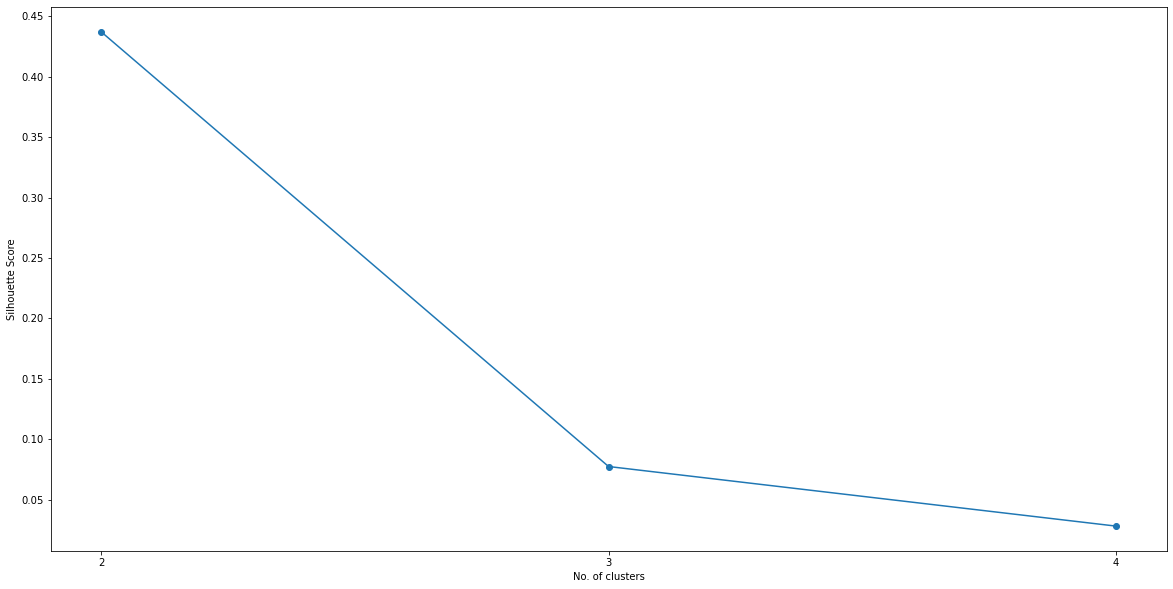

In [75]:
plot(max_range, scores, "No. of clusters", "Silhouette Score")

In [76]:
# run k-means clustering
kmeans = KMeans(n_clusters=2, random_state=0).fit(sg_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10]

array([0, 1, 0, 0, 0])

In [78]:

df_data_1.rename(columns={'District':'Neighborhood'}, inplace=True)
df_data_1.head()

,country,Districts,city,lat,lng,Unnamed: 5
0,Singapore,South West,Keat Hong Village,1.3778,103.7442,NaN
1,Singapore,South West,Choa Chu Kang New Town,1.3833,103.7500,NaN
2,Singapore,South West,Bukit Panjang Estate,1.3817,103.7525,NaN
3,Singapore,Central Singapore,Jalan Kayu,1.3972,103.8719,NaN
4,Singapore,Central Singapore,Bukit Sembawang Estate,1.3956,103.8692,NaN


In [85]:
# add clustering labels
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

sg_merged = df_data_1

# merge sgt_grouped with df_data_1 to add latitude/longitude for each neighborhood
sg_merged = df_data_1.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Districts')

sg_merged

,country,Districts,city,lat,lng,Unnamed: 5,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Singapore,South West,Keat Hong Village,1.3778,103.7442,NaN,0,Coffee Shop,Café,Chinese Restaurant,Asian Restaurant,Bus Station,Food Court,Noodle House,Seafood Restaurant,Fast Food Restaurant,Shopping Mall
1,Singapore,South West,Choa Chu Kang New Town,1.3833,103.7500,NaN,0,Coffee Shop,Café,Chinese Restaurant,Asian Restaurant,Bus Station,Food Court,Noodle House,Seafood Restaurant,Fast Food Restaurant,Shopping Mall
2,Singapore,South West,Bukit Panjang Estate,1.3817,103.7525,NaN,0,Coffee Shop,Café,Chinese Restaurant,Asian Restaurant,Bus Station,Food Court,Noodle House,Seafood Restaurant,Fast Food Restaurant,Shopping Mall
3,Singapore,Central Singapore,Jalan Kayu,1.3972,103.8719,NaN,0,Food Court,Coffee Shop,Chinese Restaurant,Bus Station,Asian Restaurant,Supermarket,Dessert Shop,Café,Fast Food Restaurant,Park
4,Singapore,Central Singapore,Bukit Sembawang Estate,1.3956,103.8692,NaN,0,Food Court,Coffee Shop,Chinese Restaurant,Bus Station,Asian Restaurant,Supermarket,Dessert Shop,Café,Fast Food Restaurant,Park
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
69,Singapore,South West,Kampong Sungai Jurong,1.3517,103.7336,NaN,0,Coffee Shop,Café,Chinese Restaurant,Asian Restaurant,Bus Station,Food Court,Noodle House,Seafood Restaurant,Fast Food Restaurant,Shopping Mall
70,Singapore,South West,Kampong Java Teban,1.3333,103.7333,NaN,0,Coffee Shop,Café,Chinese Restaurant,Asian Restaurant,Bus Station,Food Court,Noodle House,Seafood Restaurant,Fast Food Restaurant,Shopping Mall
71,Singapore,South West,Kampong Tebing Terjun,1.3333,103.7500,NaN,0,Coffee Shop,Café,Chinese Restaurant,Asian Restaurant,Bus Station,Food Court,Noodle House,Seafood Restaurant,Fast Food Restaurant,Shopping Mall
72,Singapore,South West,Kampong Sungai Pandan,1.3167,103.7500,NaN,0,Coffee Shop,Café,Chinese Restaurant,Asian Restaurant,Bus Station,Food Court,Noodle House,Seafood Restaurant,Fast Food Restaurant,Shopping Mall


In [86]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(sg_merged['lat'], sg_merged['lng'], sg_merged['Districts'], sg_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

In [87]:
#Examining cluster 0

sg_merged.loc[sg_merged['Cluster Labels'] == 0, sg_merged.columns[[1] + list(range(5, sg_merged.shape[1]))]]

,Districts,Unnamed: 5,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,South West,NaN,0,Coffee Shop,Café,Chinese Restaurant,Asian Restaurant,Bus Station,Food Court,Noodle House,Seafood Restaurant,Fast Food Restaurant,Shopping Mall
1,South West,NaN,0,Coffee Shop,Café,Chinese Restaurant,Asian Restaurant,Bus Station,Food Court,Noodle House,Seafood Restaurant,Fast Food Restaurant,Shopping Mall
2,South West,NaN,0,Coffee Shop,Café,Chinese Restaurant,Asian Restaurant,Bus Station,Food Court,Noodle House,Seafood Restaurant,Fast Food Restaurant,Shopping Mall
3,Central Singapore,NaN,0,Food Court,Coffee Shop,Chinese Restaurant,Bus Station,Asian Restaurant,Supermarket,Dessert Shop,Café,Fast Food Restaurant,Park
4,Central Singapore,NaN,0,Food Court,Coffee Shop,Chinese Restaurant,Bus Station,Asian Restaurant,Supermarket,Dessert Shop,Café,Fast Food Restaurant,Park
...,...,...,...,...,...,...,...,...,...,...,...,...,...
69,South West,NaN,0,Coffee Shop,Café,Chinese Restaurant,Asian Restaurant,Bus Station,Food Court,Noodle House,Seafood Restaurant,Fast Food Restaurant,Shopping Mall
70,South West,NaN,0,Coffee Shop,Café,Chinese Restaurant,Asian Restaurant,Bus Station,Food Court,Noodle House,Seafood Restaurant,Fast Food Restaurant,Shopping Mall
71,South West,NaN,0,Coffee Shop,Café,Chinese Restaurant,Asian Restaurant,Bus Station,Food Court,Noodle House,Seafood Restaurant,Fast Food Restaurant,Shopping Mall
72,South West,NaN,0,Coffee Shop,Café,Chinese Restaurant,Asian Restaurant,Bus Station,Food Court,Noodle House,Seafood Restaurant,Fast Food Restaurant,Shopping Mall


In [88]:
#Examining cluster

sg_merged.loc[sg_merged['Cluster Labels'] == 1, sg_merged.columns[[1] + list(range(5, sg_merged.shape[1]))]]

,Districts,Unnamed: 5,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
5,North East,NaN,1,Bus Station,Fast Food Restaurant,Vegetarian / Vegan Restaurant,Ice Cream Shop,Food Court,Park,Big Box Store,Laundromat,Drugstore,Seafood Restaurant
13,North East,NaN,1,Bus Station,Fast Food Restaurant,Vegetarian / Vegan Restaurant,Ice Cream Shop,Food Court,Park,Big Box Store,Laundromat,Drugstore,Seafood Restaurant
14,North East,NaN,1,Bus Station,Fast Food Restaurant,Vegetarian / Vegan Restaurant,Ice Cream Shop,Food Court,Park,Big Box Store,Laundromat,Drugstore,Seafood Restaurant
21,North East,NaN,1,Bus Station,Fast Food Restaurant,Vegetarian / Vegan Restaurant,Ice Cream Shop,Food Court,Park,Big Box Store,Laundromat,Drugstore,Seafood Restaurant
57,North East,NaN,1,Bus Station,Fast Food Restaurant,Vegetarian / Vegan Restaurant,Ice Cream Shop,Food Court,Park,Big Box Store,Laundromat,Drugstore,Seafood Restaurant
62,North East,NaN,1,Bus Station,Fast Food Restaurant,Vegetarian / Vegan Restaurant,Ice Cream Shop,Food Court,Park,Big Box Store,Laundromat,Drugstore,Seafood Restaurant
68,North East,NaN,1,Bus Station,Fast Food Restaurant,Vegetarian / Vegan Restaurant,Ice Cream Shop,Food Court,Park,Big Box Store,Laundromat,Drugstore,Seafood Restaurant
